In [1]:
import numpy as np
import tensorflow as tf
tf.__version__

2023-06-19 09:32:45.108067: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-19 09:32:45.990240: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


'2.12.0'

In [2]:
def process_text(file_path):
    text = open(path_to_file, 'r', encoding='utf-8', errors='replace').read()
    vocab = sorted(set(text))  # The unique characters in the file
    # Creating a mapping from unique characters to indices and vice versa
    char2idx = {u: i for i, u in enumerate(vocab)}
    idx2char = np.array(vocab)
    text_as_int = np.array([char2idx[c] for c in text])
    return text_as_int, vocab, char2idx, idx2char

In [3]:
def split_input_target(chunk):
    input_text, target_text = chunk[:-1], chunk[1:]
    return input_text, target_text

In [4]:
def create_dataset(text_as_int, seq_length=100, batch_size=64, buffer_size=10000):
    char_dataset = tf.data.Dataset.from_tensor_slices(text_as_int)
    dataset = char_dataset.batch(seq_length + 1, drop_remainder=True).map(split_input_target)
    dataset = dataset.shuffle(buffer_size).batch(batch_size, drop_remainder=True)
    return dataset

### Model1: 2 Simple RNN layers, With Regularization, Adam optimization, Epoch set = 50

In [5]:
def build_model(vocab_size, embedding_dim=256, rnn_units=1024, batch_size=64):
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size, embedding_dim, batch_input_shape=[batch_size, None]),
        tf.keras.layers.SimpleRNN(rnn_units, return_sequences=True, stateful=True, recurrent_initializer='glorot_uniform'),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.SimpleRNN(rnn_units, return_sequences=True, stateful=True, recurrent_initializer='glorot_uniform'),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(vocab_size)  # Default activation: 'linear'
    ])
    return model

In [6]:
def loss(labels, logits):
    return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)

In [7]:
def generate_text(model, char2idx, idx2char, start_string, generate_char_num=1000, temperature=1.0):
    # Evaluation step (generating text using the learned model)
    # Low temperatures results in more predictable text, higher temperatures results in more surprising text.
    # Converting our start string to numbers (vectorizing)
    input_eval = [char2idx[s] for s in start_string]
    input_eval = tf.expand_dims(input_eval, 0)
    text_generated = []  # Empty string to store our results
    model.reset_states()
    for i in range(generate_char_num):
        predictions = model(input_eval)
        predictions = tf.squeeze(predictions, 0)    # remove the batch dimension
        predictions /= temperature
        # using a categorical distribution to predict the character returned by the model
        predicted_id = tf.random.categorical(predictions, num_samples=1)[-1, 0].numpy()
        # We pass the predicted character as the next input to the model along with the previous hidden state
        input_eval = tf.expand_dims([predicted_id], axis=0)
        text_generated.append(idx2char[predicted_id])
    return start_string + ''.join(text_generated)

In [8]:
# path_to_file = tf.keras.utils.get_file('nietzsche.txt', 'https://s3.amazonaws.com/text-datasets/nietzsche.txt')
path_to_file = 'Data/SherlockHolmes.txt'

text_as_int, vocab, char2idx, idx2char = process_text(path_to_file)
dataset = create_dataset(text_as_int)
model = build_model(vocab_size=len(vocab))
model.compile(optimizer='adam', loss=loss, metrics=['accuracy'])
model.summary()
history = model.fit(dataset, epochs=50)
model.save_weights("gen_text_weights.h5", save_format='h5')
# To keep this prediction step simple, use a batch size of 1
model = build_model(vocab_size=len(vocab), batch_size=1)
model.load_weights("gen_text_weights.h5")
model.summary()

2023-06-19 06:18:20.479588: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9599 MB memory:  -> device: 0, name: GeForce RTX 2080 Ti, pci bus id: 0000:06:00.0, compute capability: 7.5


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (64, None, 256)           23296     
                                                                 
 simple_rnn (SimpleRNN)      (64, None, 1024)          1311744   
                                                                 
 dropout (Dropout)           (64, None, 1024)          0         
                                                                 
 batch_normalization (BatchN  (64, None, 1024)         4096      
 ormalization)                                                   
                                                                 
 simple_rnn_1 (SimpleRNN)    (64, None, 1024)          2098176   
                                                                 
 dropout_1 (Dropout)         (64, None, 1024)          0         
                                                        

2023-06-19 06:18:21.238976: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int64 and shape [3381940]
	 [[{{node Placeholder/_0}}]]
2023-06-19 06:18:21.239359: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int64 and shape [3381940]
	 [[{{node Placeholder/_0}}]]
2023-06-19 06:18:25.222094: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x557b12813b80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-06-19 06:18:25.222156: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): GeForce 

523/523 [==============================] - 112s 201ms/step - loss: 2.4510 - accuracy: 0.3499
Epoch 2/50
523/523 [==============================] - 101s 190ms/step - loss: 1.6875 - accuracy: 0.5045
Epoch 3/50
523/523 [==============================] - 101s 189ms/step - loss: 1.5031 - accuracy: 0.5552
Epoch 4/50
523/523 [==============================] - 102s 190ms/step - loss: 1.4153 - accuracy: 0.5793
Epoch 5/50
523/523 [==============================] - 102s 191ms/step - loss: 1.3635 - accuracy: 0.5931
Epoch 6/50
523/523 [==============================] - 102s 192ms/step - loss: 1.3283 - accuracy: 0.6028
Epoch 7/50
523/523 [==============================] - 100s 187ms/step - loss: 1.3125 - accuracy: 0.6071
Epoch 8/50
523/523 [==============================] - 102s 192ms/step - loss: 1.2892 - accuracy: 0.6131
Epoch 9/50
523/523 [==============================] - 102s 191ms/step - loss: 1.2739 - accuracy: 0.6171
Epoch 10/50
523/523 [==============================] - 100s 189ms/step - lo

In [9]:
import matplotlib.pyplot as plt
def plot_graphs(history,string):
    plt.plot(history.history[string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.show()

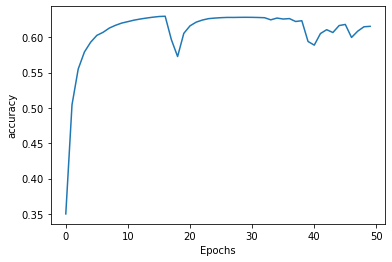

In [10]:
plot_graphs(history,'accuracy')

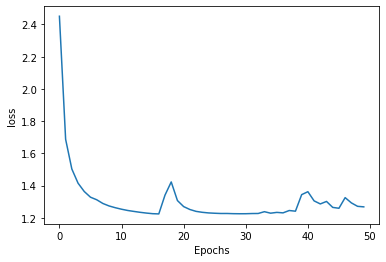

In [11]:
plot_graphs(history,'loss')

In [12]:
import time
user_input = input("Write the beginning of the text, the program will complete it. Your input is: ")
start = time.time()
generated_text = generate_text(model, char2idx, idx2char, start_string=user_input, generate_char_num=1000)
end = time.time()
print(generated_text)
print('\nRun time:', end - start)

Write the beginning of the text, the program will complete it. Your input is: There is a line on the letter saying the object he saw was so horrible and he could not even figure out what it was
There is a line on the letter saying the object he saw was so horrible and he could not even figure out what it was nefriving for his
     fit, which may be worked someone could be
     been the out sketches which was that I have a matter, but thede were all the dog-end--ther you, wert one have hund its and no deftally house  "someof what we stooped upon its gets whech never found my command foely, thereeress well, a man he diend the seat, and the connintentie coach are together to lay which I have no explained the
     study. Tir, dayter one secretion as to say."
     I internable than Mr. Can you were taken to all enough to take againing her work of her house, lheak was going to be approaring the land who commentration upon that day?"

             South. "I hide most convincing-nenger, and be

### Model2: 2 Simple RNN layers, With Regularization, Adam optimization, Epoch set = 25

In [8]:
# path_to_file = tf.keras.utils.get_file('nietzsche.txt', 'https://s3.amazonaws.com/text-datasets/nietzsche.txt')
path_to_file = 'Data/SherlockHolmes.txt'

text_as_int, vocab, char2idx, idx2char = process_text(path_to_file)
dataset = create_dataset(text_as_int)
model = build_model(vocab_size=len(vocab))
model.compile(optimizer='adam', loss=loss, metrics=['accuracy'])
model.summary()
history = model.fit(dataset, epochs=25)
model.save_weights("gen_text_weights.h5", save_format='h5')
# To keep this prediction step simple, use a batch size of 1
model = build_model(vocab_size=len(vocab), batch_size=1)
model.load_weights("gen_text_weights.h5")
model.summary()

2023-06-19 09:33:00.640143: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9599 MB memory:  -> device: 0, name: GeForce RTX 2080 Ti, pci bus id: 0000:06:00.0, compute capability: 7.5


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (64, None, 256)           23296     
                                                                 
 simple_rnn (SimpleRNN)      (64, None, 1024)          1311744   
                                                                 
 dropout (Dropout)           (64, None, 1024)          0         
                                                                 
 batch_normalization (BatchN  (64, None, 1024)         4096      
 ormalization)                                                   
                                                                 
 simple_rnn_1 (SimpleRNN)    (64, None, 1024)          2098176   
                                                                 
 dropout_1 (Dropout)         (64, None, 1024)          0         
                                                        

2023-06-19 09:33:01.330420: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int64 and shape [3381940]
	 [[{{node Placeholder/_0}}]]
2023-06-19 09:33:01.330766: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int64 and shape [3381940]
	 [[{{node Placeholder/_0}}]]
2023-06-19 09:33:05.059745: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7ff32c018b90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-06-19 09:33:05.059812: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): GeForce 

523/523 [==============================] - 108s 195ms/step - loss: 2.3870 - accuracy: 0.3661
Epoch 2/25
523/523 [==============================] - 101s 190ms/step - loss: 1.6788 - accuracy: 0.5084
Epoch 3/25
523/523 [==============================] - 100s 187ms/step - loss: 1.5065 - accuracy: 0.5560
Epoch 4/25
523/523 [==============================] - 100s 188ms/step - loss: 1.4166 - accuracy: 0.5805
Epoch 5/25
523/523 [==============================] - 99s 186ms/step - loss: 1.3683 - accuracy: 0.5932
Epoch 6/25
523/523 [==============================] - 99s 185ms/step - loss: 1.3287 - accuracy: 0.6040
Epoch 7/25
523/523 [==============================] - 97s 182ms/step - loss: 1.3025 - accuracy: 0.6108
Epoch 8/25
523/523 [==============================] - 101s 190ms/step - loss: 1.2835 - accuracy: 0.6160
Epoch 9/25
523/523 [==============================] - 98s 185ms/step - loss: 1.2690 - accuracy: 0.6195
Epoch 10/25
523/523 [==============================] - 100s 188ms/step - loss: 

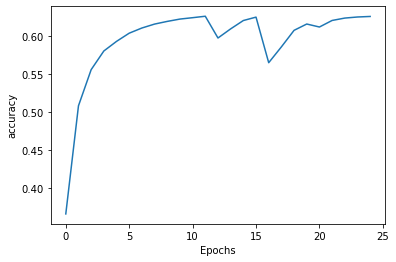

In [11]:
plot_graphs(history,'accuracy')

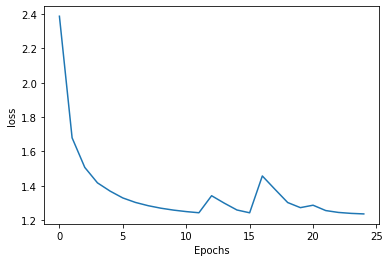

In [12]:
plot_graphs(history, 'loss')

In [13]:
user_input = input("Write the beginning of the text, the program will complete it. Your input is: ")
start = time.time()
generated_text = generate_text(model, char2idx, idx2char, start_string=user_input, generate_char_num=1000)
end = time.time()
print(generated_text)
print('\nRun time:', end - start)

Write the beginning of the text, the program will complete it. Your input is: There is a line on the letter saying the object he saw was so horrible and he could not even figure out what it was
There is a line on the letter saying the object he saw was so horrible and he could not even figure out what it was brought me out and
     attracted, and all weache because, an
     ilice man, with a clubty, hu daw feeling, in that woman
     as effect the imphigu'lut, the thing were of a few ported away, to my young."
, he none appused to speak a sharp success which comes down him to do?"

     "There are another
     world had not was seen and the knock he rememberes, which was very estable, though he had been
     golden. "Tell you will ask that chance
     who had been so much sending mimsown
     scream of
     hee when I had a
     break young man guide and know about
     what I want of the
     workness by advelope these like to see in some continuas? He could never come my cab.
     An